In [1]:
# Adapted from https://www.tensorflow.org/tutorials/generative/pix2pix under the following licence:

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [2]:
import tensorflow as tf
from keras import backend as K

import os
import pathlib
import time
import datetime
import numpy as np

from matplotlib import pyplot as plt
from IPython import display

2023-08-16 12:49:07.962263: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-16 12:49:08.007268: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-16 12:49:08.008762: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-16 12:49:08.873063: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## Load Dataset

In [3]:
PATH = "Data/SpiralGalaxy/test/"

In [24]:
sample_image_org = tf.io.read_file(str(PATH+'apod_1995-07-24_gray_resized.png'))
sample_image_org = tf.io.decode_png(sample_image_org)
sample_image_org = sample_image_org[:,:,:-1]
print(sample_image_org.shape)

sample_image_fft = tf.io.read_file(str(PATH+'apod_1995-07-24_fft_norm.png'))
sample_image_fft = tf.io.decode_png(sample_image_fft)
sample_image_fft = sample_image_fft[:,:,:-1]
print(sample_image_fft.shape)

## Why the heck 4???????

(64, 64, 3)
(64, 64, 3)


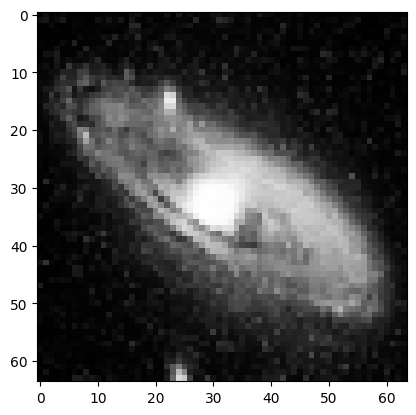

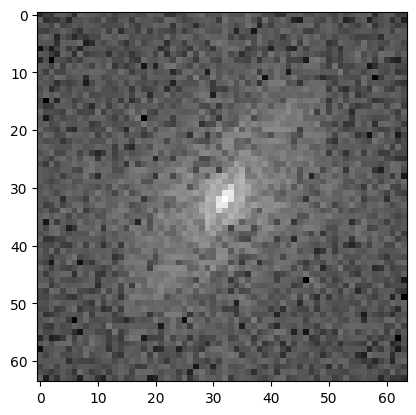

In [5]:
plt.figure()
plt.imshow(sample_image_org)
plt.figure()
plt.imshow(sample_image_fft)

In [ ]:
sample_image_org = tf.io.read_file(str(PATH+'apod_1995-07-24_gray_resized.png'))
sample_image_org = tf.io.decode_png(sample_image_org)
sample_image_org = sample_image_org[:,:,:-1]
print(sample_image_org.shape)

sample_image_fft = tf.io.read_file(str(PATH+'apod_1995-07-24_fft_norm.png'))
sample_image_fft = tf.io.decode_png(sample_image_fft)
sample_image_fft = sample_image_fft[:,:,:-1]
print(sample_image_fft.shape)

## Why the heck 4???????

In [82]:
# Load function

def load(image_file):
  # Read and decode an image file to a uint8 tensor
  image = tf.io.read_file(image_file)
  image = tf.io.decode_jpeg(image)

  # Split each image tensor into two tensors:
  # - one with a real building facade image
  # - one with an architecture label image 
  w = tf.shape(image)[1]
  w = w // 2
  input_image = image[:, w:, :]
  real_image = image[:, :w, :]

  # Convert both images to float32 tensors
  input_image = tf.cast(input_image, tf.float32)
  real_image = tf.cast(real_image, tf.float32)

  return input_image, real_image

## Preprocessing

In [6]:
training_size = 1200
# The batch size of 1 produced better results for the U-Net in the original pix2pix experiment
BATCH_SIZE = 1
img_size = 64

In [7]:
def resize(input_image, real_image, height, width):
  input_image = tf.image.resize(input_image, [height, width],
                                method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
  real_image = tf.image.resize(real_image, [height, width],
                               method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

  return input_image, real_image

In [8]:
def random_crop(input_image, real_image):
  stacked_image = tf.stack([input_image, real_image], axis=0)
  cropped_image = tf.image.random_crop(
      stacked_image, size=[2, img_size, img_size, 3])

  return cropped_image[0], cropped_image[1]

In [9]:
# Normalizing the images to [-1, 1]
def normalize(input_image, real_image):
  input_image = (input_image / 127.5) - 1
  real_image = (real_image / 127.5) - 1

  return input_image, real_image

In [10]:
@tf.function()
def random_jitter(input_image, real_image):
  # Resizing to 286x286
  input_image, real_image = resize(input_image, real_image, 68, 68)

  # Random cropping back to 256x256
  input_image, real_image = random_crop(input_image, real_image)

  if tf.random.uniform(()) > 0.5:
    # Random mirroring
    input_image = tf.image.flip_left_right(input_image)
    real_image = tf.image.flip_left_right(real_image)

  return input_image, real_image

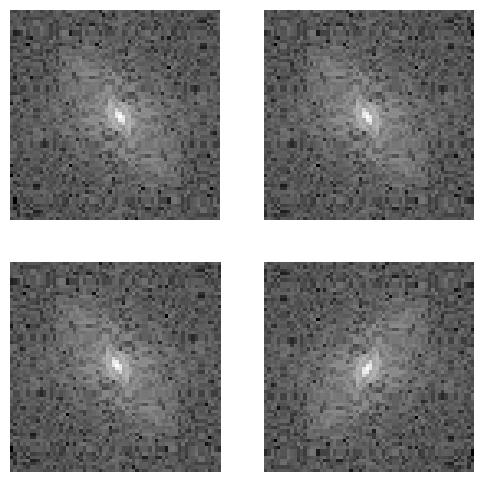

In [14]:
# Check if random_jitter works:
plt.figure(figsize=(6, 6))
for i in range(4):
  rj_inp, rj_re = random_jitter(sample_image_fft, sample_image_org)
  plt.subplot(2, 2, i + 1)
  plt.imshow(rj_inp)# / 255.0)
  plt.axis('off')
plt.show()

### Helper functions

In [15]:
def load_image_train(image_file):
  input_image, real_image = load(image_file)
  input_image, real_image = random_jitter(input_image, real_image)
  input_image, real_image = normalize(input_image, real_image)

  return input_image, real_image

In [16]:
def load_image_test(image_file):
  input_image, real_image = load(image_file)
  input_image, real_image = resize(input_image, real_image,
                                   IMG_HEIGHT, IMG_WIDTH)
  input_image, real_image = normalize(input_image, real_image)

  return input_image, real_image

# Split train, test and validation datasets:

train_dataset = tf.data.Dataset.list_files(str(PATH + '/train/*.jpg'))
train_dataset = train_dataset.map(load_image_train,
                                  num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.batch(BATCH_SIZE)

try:
  test_dataset = tf.data.Dataset.list_files(str(PATH + '/test/*.jpg'))
except tf.errors.InvalidArgumentError:
  test_dataset = tf.data.Dataset.list_files(str(PATH + '/val/*.jpg'))
test_dataset = test_dataset.map(load_image_test)
test_dataset = test_dataset.batch(BATCH_SIZE)

## Build Generator

In [17]:
OUTPUT_CHANNELS = 3

In [18]:
# Encoder (downsample):
def downsample(filters, size, apply_batchnorm=True):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
      tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, data_format="channels_last",
                             use_bias=False))

  if apply_batchnorm:
    result.add(tf.keras.layers.BatchNormalization())

  result.add(tf.keras.layers.LeakyReLU())

  return result

In [19]:
down_model = downsample(3, 4)
down_result = down_model(tf.expand_dims(tf.cast(sample_image_fft, float), 0))
#down_result = down_model(tf.expand_dims(sample_image, 0))
print (down_result.shape)

(1, 32, 32, 3)


In [20]:
# Decoder (upsample):

def upsample(filters, size, apply_dropout=False):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
    tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                    padding='same',
                                    kernel_initializer=initializer,
                                    data_format="channels_last",
                                    use_bias=False))

  result.add(tf.keras.layers.BatchNormalization())

  if apply_dropout:
      result.add(tf.keras.layers.Dropout(0.5))

  result.add(tf.keras.layers.ReLU())

  return result

In [21]:
up_model = upsample(3, 4, apply_dropout=True)
up_result = up_model(down_result)
print (up_result.shape)

(1, 64, 64, 3)


In [22]:
def Generator():
  inputs = tf.keras.layers.Input(shape=[64, 64, 3])

  down_stack = [
    downsample(64, 4, apply_batchnorm=False),  # (batch_size, 128, 128, 64)
    downsample(128, 4),  # (batch_size, 64, 64, 128)
    downsample(256, 4),  # (batch_size, 32, 32, 256)
    downsample(512, 4),  # (batch_size, 16, 16, 512)
    downsample(512, 4),  # (batch_size, 8, 8, 512)
    downsample(512, 4),  # (batch_size, 4, 4, 512)
    #downsample(512, 4),  # (batch_size, 2, 2, 512)
    #downsample(512, 4), # (batch_size, 1, 1, 512)
  ]

  up_stack = [
    #upsample(512, 4, apply_dropout=True),  # (batch_size, 2, 2, 1024)
    #upsample(512, 4, apply_dropout=True),  # (batch_size, 4, 4, 1024)
    upsample(512, 4, apply_dropout=True),  # (batch_size, 8, 8, 1024)
    upsample(512, 4),  # (batch_size, 16, 16, 1024)
    upsample(256, 4),  # (batch_size, 32, 32, 512)
    upsample(128, 4),  # (batch_size, 64, 64, 256)
    upsample(64, 4),  # (batch_size, 128, 128, 128)
  ]

  initializer = tf.random_normal_initializer(0., 0.02)
  last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                         strides=2,
                                         padding='same',
                                         kernel_initializer=initializer,
                                         activation='tanh')  # (batch_size, 256, 256, 3)

  x = inputs

  # Downsampling through the model
  skips = []
  for down in down_stack:
    x = down(x)
    #print(x)
    skips.append(x)

  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    #print(x)
    x = tf.keras.layers.Concatenate()([x, skip])

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

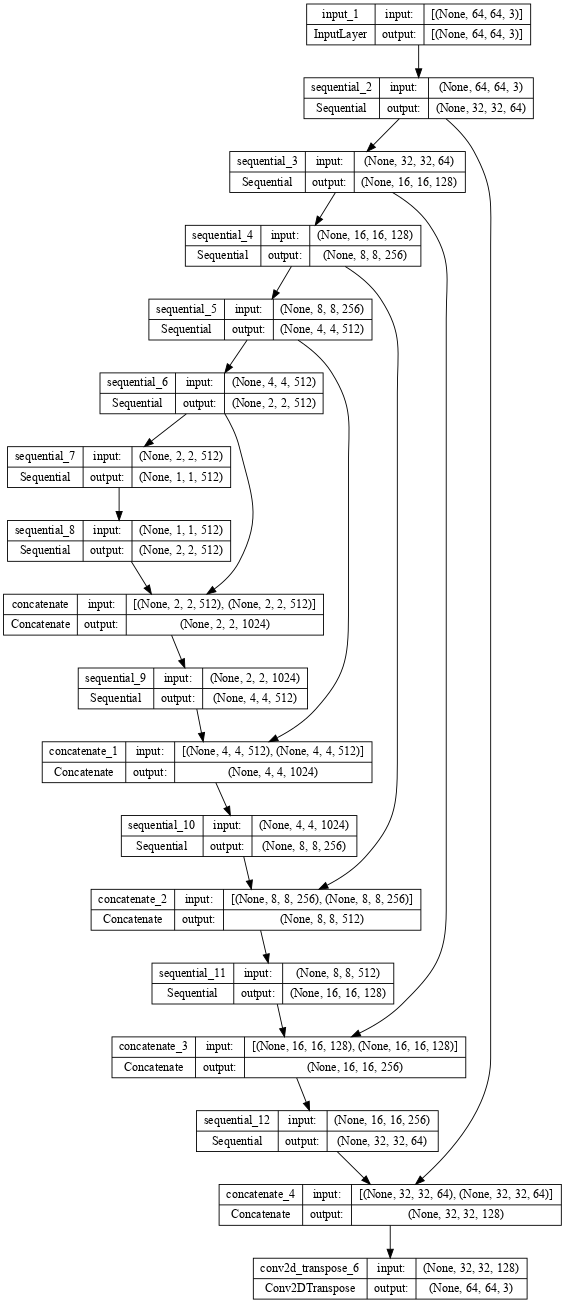

In [23]:
generator = Generator()
tf.keras.utils.plot_model(generator, show_shapes=True, dpi=64)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


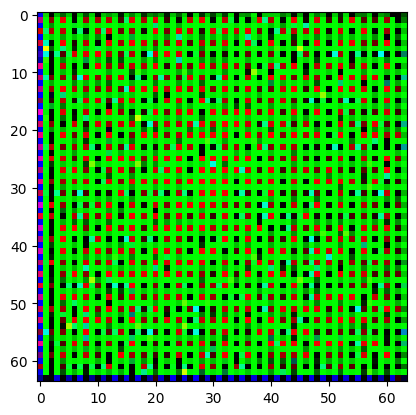

In [47]:
gen_output = generator(sample_image_fft[tf.newaxis, ...], training=False)
plt.imshow(gen_output[0, ...])

### Generator loss

In [28]:
# I don't really understand this part (yet), but it was proposed in the pix2pix paper, so...
LAMBDA = 100
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def generator_loss(disc_generated_output, gen_output, target):
  gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)

  # Mean absolute error
  l1_loss = tf.reduce_mean(tf.abs(target - gen_output))

  total_gen_loss = gan_loss + (LAMBDA * l1_loss)

  return total_gen_loss, gan_loss, l1_loss

# Build the Discriminator 

In [29]:
# Same here

In [42]:
def Discriminator():
  initializer = tf.random_normal_initializer(0., 0.02)

  inp = tf.keras.layers.Input(shape=[64, 64, 3], name='input_image')
  tar = tf.keras.layers.Input(shape=[64, 64, 3], name='target_image')

  x = tf.keras.layers.concatenate([inp, tar])  # (batch_size, 256, 256, channels*2)

  down1 = downsample(32, 4, False)(x)  # (batch_size, 128, 128, 64)
  down2 = downsample(64, 4)(down1)  # (batch_size, 64, 64, 128)
  #down3 = downsample(256, 4)(down2)  # (batch_size, 32, 32, 256)

  zero_pad1 = tf.keras.layers.ZeroPadding2D()(down2)  # (batch_size, 34, 34, 256)
  conv = tf.keras.layers.Conv2D(256, 4, strides=1,
                                kernel_initializer=initializer,
                                use_bias=False)(zero_pad1)  # (batch_size, 31, 31, 512)

  batchnorm1 = tf.keras.layers.BatchNormalization()(conv)

  leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)

  zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu)  # (batch_size, 33, 33, 512)

  last = tf.keras.layers.Conv2D(1, 4, strides=1,
                                kernel_initializer=initializer)(zero_pad2)  # (batch_size, 30, 30, 1)

  return tf.keras.Model(inputs=[inp, tar], outputs=last)

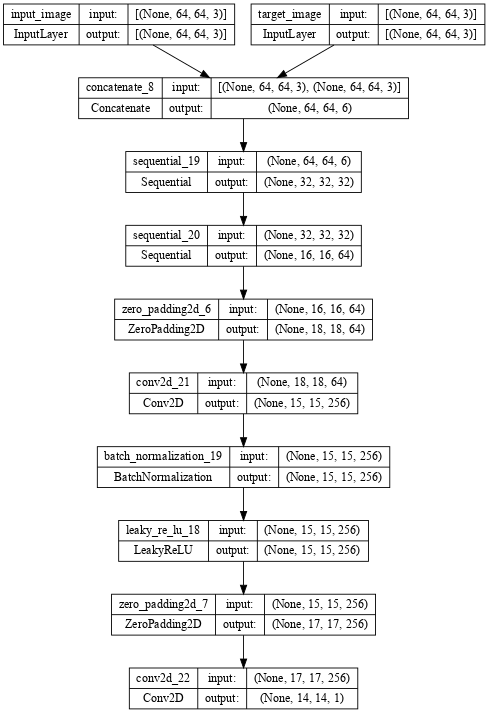

In [46]:
discriminator = Discriminator()
tf.keras.utils.plot_model(discriminator, show_shapes=True, dpi=64)

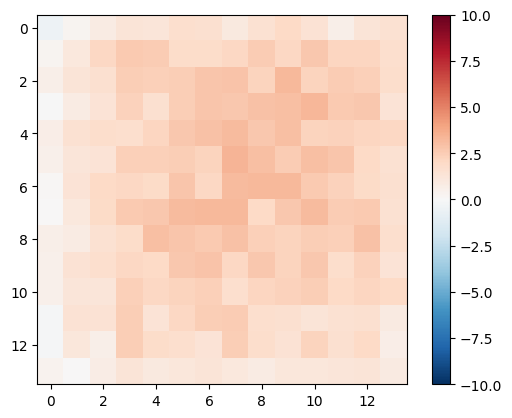

In [53]:
sample_image_fft_ed = sample_image_fft

disc_out = discriminator([sample_image_fft[tf.newaxis, :], gen_output], training=False)
plt.imshow(disc_out[0, ..., -1], vmin=-10, vmax=10, cmap='RdBu_r')
plt.colorbar()

### Disciminator loss

In [55]:
def discriminator_loss(disc_real_output, disc_generated_output):
  real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)

  generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)

  total_disc_loss = real_loss + generated_loss

  return total_disc_loss

## Optimizer

In [56]:
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [57]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [58]:
## Generate Images

In [78]:
def generate_images(model, test_input, tar):
  prediction = model(test_input, training=True)
  plt.figure(figsize=(15, 15))

  display_list = [test_input[0], tar[0], prediction[0]*0.5 + 0.5]
  title = ['Input Image', 'Ground Truth', 'Predicted Image']

  for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.title(title[i])
    # Getting the pixel values in the [0, 1] range to plot.
    plt.imshow(display_list[i]) # * 0.5 + 0.5)
    plt.axis('off')
  plt.show()

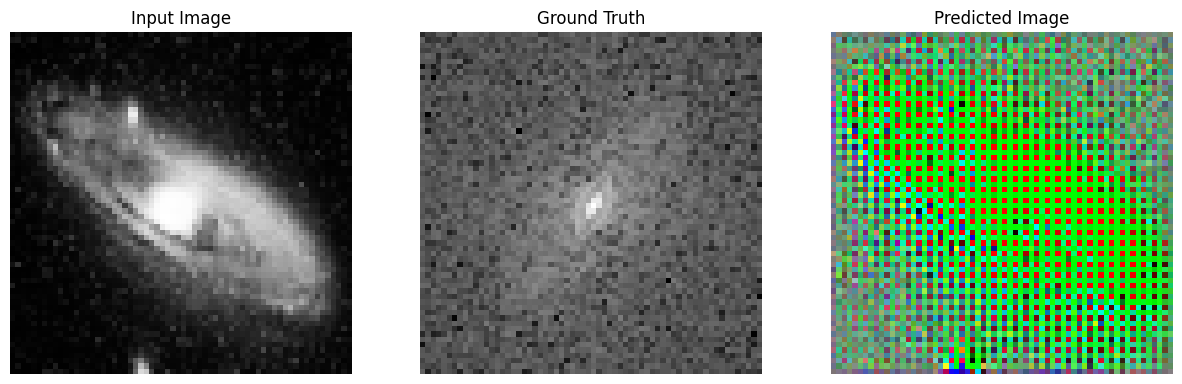

In [79]:
example_input = sample_image_org[tf.newaxis, :]
example_target = sample_image_fft[tf.newaxis, :]

generate_images(generator, example_input, example_target)